### Libraries

In [1]:
%matplotlib inline

# Libraries
import os
import numpy as np
import pandas as pd

from os.path import join

from library.cima.domain_utils import get_grid, get_file_shp, get_file_json, create_points_shp
from library.cima.ts_utils import df_time_matching, df_temporal_matching, df_period_selection
from library.cima.ts_dset_reader import dset_init, dset_config, dset_period

from pytesmo.scaling import get_scaling_function, get_scaling_method_lut

from pytesmo.time_series.filters import exp_filter
from pytesmo.time_series import anomaly

import matplotlib.pyplot as plt

# Info
print('Libraries loaded!')

Libraries loaded!


### Exercise Configuration
In the configuration part:
* select your basin
* set correct paths of the data
* select time period of datasets
* set thresholds of snow and frozen conditions to filter ASCAT dataset

An example about how to organize static and dynamic data is reported.
- **structure of static data**: shapefile and grid files
![data_static_structure.png](attachment:data_static_structure.png)

- **structure of dynamic data**: ASCAT, ERA5 and RZSM datasets
![dynamic_data_structure.png](attachment:dynamic_data_structure.png)

In [2]:
# Domain
domain = 'italy'
file_shp_domain = 'po_basin.shp'
file_tiff_domain = 'po_basin.tiff'

# Path(s)
data_path_dyn = os.path.join('/','home','fabio','hsaf_data', 'dynamic')
data_path_static = os.path.join('/','home','fabio','hsaf_data', 'static')

tmp_path = os.path.join('tmp')
img_path = os.path.join('img')

ascat_path_ts = os.path.join(data_path_dyn, 'ascat_dr', domain)
ascat_path_grid = os.path.join(data_path_static, 'warp5_grid')
ascat_path_layers = os.path.join(data_path_static, 'warp5_layers')
ascat_path_tmp = os.path.join(tmp_path, 'ascat')

era5_path_ts = os.path.join(data_path_dyn, 'era5_ts', domain)
era5_path_grid = os.path.join(data_path_dyn, 'era5_ts', domain)
era5_path_tmp = os.path.join(tmp_path, 'era5')

rzsm_path_ts = os.path.join(data_path_dyn, 'rzsm_ts', domain)
rzsm_path_grid = os.path.join(data_path_dyn, 'rzsm_ts', domain)
rzsm_path_tmp = os.path.join(tmp_path, 'rzsm')

domain_path_layer = os.path.join(data_path_static, 'shp', domain)
exercize_path_img = os.path.join(img_path)

# Parameters
ascat_mask_frozen_prob_threshold = 100 # if mask value is greater than threshold the value is discarded
ascat_mask_snow_prob_threshold = 100   # if mask value is greater than threshold the value is discarded

time_start = "2007-01-01" # format "%Y-%m-%d"
time_end = "2014-12-31"   # "format %Y-%m-%d"  

temporal_matching = 24
temporal_drop_duplicates = False

max_dist = 35000

# Create img path
if not os.path.exists(exercize_path_img):
    os.makedirs(exercize_path_img)

### Scaling methods
Available methods on pytesmo package are:
* **min-max correction** (min_max) - scales the input datasets so that they have the same minimum and maximum afterward
* **linear rescaling** (mean_std) - scales the input datasets so that they have the same mean and standard deviation afterwards
* **linear regression** (linreg) - scales the input datasets using linear regression
* **cdf matching** (cdf_match) - computes cumulative density functions of src and ref at their respective bin-edges by 5th order spline interpolation; then matches CDF of src to CDF of ref
* **linear cdf matching** (lin_cdf_match) - computes cumulative density functions of src and ref at their respective bin-edges by linear interpolation; then matches CDF of src to CDF of ref

In [3]:
# Get scaling methods available on pytesmo
scaling_methods = get_scaling_method_lut()
# Print available methods
print(scaling_methods.keys())

['min_max', 'mean_std', 'linreg', 'cdf_match', 'lin_cdf_match']


In [4]:
# Get scaling method
scaling_method_lr = get_scaling_function('linreg')
scaling_method_ms = get_scaling_function('mean_std')

### Basin Configuration
The script loads the shapefile of the basin and creates a mask using the defined cell_size (degree) and boudary box buffer (bbox_ext in degree). 
After running the cell, results can be check using QGIS. 

In [5]:
# Get basin information using a shapefile
basin_rows, basin_cols, basin_epsg, basin_transform, basin_meta_reference = get_file_shp(
    os.path.join(domain_path_layer, file_shp_domain),
    os.path.join(domain_path_layer, file_tiff_domain),
    cell_size=0.05, bbox_ext=0)
# Print information about basin 
print(basin_rows, basin_cols, basin_epsg, basin_transform)

(53, 121, 'EPSG:4326', Affine(0.05, 0.0, 6.523501860842905,
       0.0, -0.05, 46.676799344314645))


/home/fabio/hsaf_conda/envs/work_env/lib/python2.7/site-packages/rasterio/features.py:303: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)
/home/fabio/hsaf_conda/envs/work_env/lib/python2.7/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


In [6]:
# Create basin grid using WARP5 reference system
basin_grid, basin_lons_2d, basin_lats_2d, basin_bbox = get_grid(
    os.path.join(domain_path_layer, file_tiff_domain))
# Print information about basin 
print(basin_bbox)
# Using QGIS to:
# 1) load basin shapefile
# 2) load basin tiff
# 3) check results

BoundingBox(left=6.523501860842905, bottom=44.02679934431465, right=12.573501860842907, top=46.676799344314645)


### Datasets configuration
In this part ASCAT, ERA5 and RZSM datasets are configured using parameters and paths set previously.
- Step 1 -- Create settings dictionary to summarize information about datasets

In [7]:
# Create ASCAT, ERA5 and RZSM settings
settings = {  
    "ascat_path_ts": ascat_path_ts,
    "ascat_path_grid": ascat_path_grid,
    "ascat_path_layer": ascat_path_layers,
    "ascat_path_tmp": ascat_path_tmp,
    "ascat_mask_frozen_prob_threshold": ascat_mask_frozen_prob_threshold,
    "ascat_mask_snow_prob_threshold": ascat_mask_snow_prob_threshold,
    "era5_path_ts": era5_path_ts,
    "era5_path_grid": era5_path_grid,
    "era5_path_tmp": era5_path_tmp,
    "rzsm_path_ts": rzsm_path_ts,
    "rzsm_path_grid": rzsm_path_grid,
    "rzsm_path_tmp": rzsm_path_tmp,
    "domain_path_layer": domain_path_layer,
    "time_start": time_start,
    "time_end": time_end,
    "temporal_matching": temporal_matching,
    "temporal_drop_duplicates": temporal_drop_duplicates,
    "max_dist": max_dist
}
# Print information about ASCAT and ERA5 settings
for key, value in settings.items():
    print(str(key) + ": " + str(settings[key]))

ascat_path_layer: /home/fabio/hsaf_data/static/warp5_layers
era5_path_ts: /home/fabio/hsaf_data/dynamic/era5_ts/italy
era5_path_tmp: tmp/era5
ascat_mask_frozen_prob_threshold: 100
domain_path_layer: /home/fabio/hsaf_data/static/shp/italy
era5_path_grid: /home/fabio/hsaf_data/dynamic/era5_ts/italy
time_end: 2014-12-31
rzsm_path_ts: /home/fabio/hsaf_data/dynamic/rzsm_ts/italy
temporal_drop_duplicates: False
temporal_matching: 24
max_dist: 35000
ascat_mask_snow_prob_threshold: 100
ascat_path_tmp: tmp/ascat
rzsm_path_grid: /home/fabio/hsaf_data/dynamic/rzsm_ts/italy
time_start: 2007-01-01
rzsm_path_tmp: tmp/rzsm
ascat_path_grid: /home/fabio/hsaf_data/static/warp5_grid
ascat_path_ts: /home/fabio/hsaf_data/dynamic/ascat_dr/italy


* Step 2 -- Initialize and configure reader objects for ASCAT, ERA5 and RZSM datasets

In [8]:
# Initialize ASCAT, ERA5, RZSM datasets
reader_ascat, reader_era5, reader_rzsm = dset_init(settings)
datasets = dset_config(reader_ascat, reader_era5, reader_rzsm, settings)
# Print information about ASCAT and ERA5 datasets
print("ASCAT dataset settings: " + str(datasets["ASCAT"]))
print("ERA5 dataset settings: " + str(datasets["ERA5"]))
print("RZSM dataset settings: " + str(datasets["RZSM"]))

ASCAT dataset settings: {'args': [], 'type': 'reference', 'class': <library.cima.ts_dset_driver.ASCAT_Dataset_DR object at 0x7f529450e350>, 'columns': ['sm'], 'kwargs': {'mask_snow_prob': 100, 'mask_frozen_prob': 100}}
ERA5 dataset settings: {'use_lut': True, 'lut_max_dist': 35000, 'grids_compatible': False, 'type': 'other', 'class': <library.cima.ts_dset_driver.ERA5_Dataset_TS object at 0x7f529450e4d0>, 'columns': ['tp', 'tsk']}
RZSM dataset settings: {'use_lut': True, 'lut_max_dist': 35000, 'grids_compatible': False, 'type': 'other', 'class': <library.cima.ts_dset_driver.RZSM_Dataset_TS object at 0x7f529450e590>, 'columns': ['var40', 'var41', 'var42', 'var43']}


- Step 3 -- Find GPIS of ASCAT, ERA5 and RZSM datasets using basin reference

In [9]:
# Create ASCAT and ERA5 grid(s) using basin information
# Get ascat gpi(s)
gpis_ascat, lats_ascat, lons_ascat = reader_ascat.grid.get_bbox_grid_points(
    latmin=basin_bbox.bottom, latmax=basin_bbox.top, lonmin=basin_bbox.left,
    lonmax=basin_bbox.right, both=True)
gpis_ascat_n = gpis_ascat.__len__()
# Get era5 gpi(s)
gpis_era5, lats_era5, lons_era5 = reader_era5.grid.get_bbox_grid_points(
    latmin=basin_bbox.bottom, latmax=basin_bbox.top, lonmin=basin_bbox.left,
    lonmax=basin_bbox.right, both=True)
gpis_era5_n = gpis_era5.__len__()
# Get rzsm gpi(s)
gpis_rzsm, lats_rzsm, lons_rzsm = reader_rzsm.grid.get_bbox_grid_points(
    latmin=basin_bbox.bottom, latmax=basin_bbox.top, lonmin=basin_bbox.left,
    lonmax=basin_bbox.right, both=True)
gpis_rzsm_n = gpis_rzsm.__len__()

# Print information about ASCAT, ERA5 and RZSM gpi(s) numerosity
print("ASCAT GPIS N: " + str(gpis_ascat_n))
print("ERA5 GPIS N: " + str(gpis_era5_n))
print("RZSM GPIS N: " + str(gpis_rzsm_n))

ASCAT GPIS N: 840
ERA5 GPIS N: 240
RZSM GPIS N: 817


- Step 4 -- Verify, for each dataset, if there are enough gpis inside the basin.
Using QGIS, load the created shapefiles and results should be as follows.
![basin_italy_gpis.png](attachment:basin_italy_gpis.png)

In [10]:
# Find ASCAT gpi(s) over basin (using a maximum distance parameter)
luts_ascat = reader_ascat.grid.calc_lut(basin_grid, max_dist=settings['max_dist'])
gpis_basin_ascat = np.unique(luts_ascat[gpis_ascat])
lons_basin_ascat, lats_basin_ascat = basin_grid.gpi2lonlat(gpis_basin_ascat)
# Create shapefile of ASCAT gpi(s) over basin
create_points_shp(gpis_basin_ascat, lons_basin_ascat, lats_basin_ascat, 
                  file_name_shp=os.path.join(domain_path_layer, 'ex3_basin_ascat.shp'))
# Print ASCAT gpi(s) ID
print("ASCAT Basin GPIS: " + str(gpis_basin_ascat))

/home/fabio/hsaf_conda/envs/work_env/lib/python2.7/site-packages/pygeogrids/nearest_neighbor.py:191: RuntimeWarning: invalid value encountered in sqrt
  d, ind = self.kdtree.query(query_coords, distance_upper_bound=max_dist)


ASCAT Basin GPIS: [ 245  248  251  254  257  260  263  267  270  273  276  279  307  310
  313  317  320  323  326  329  332  335  338  342  345  348  351  354
  357  360  363  489  492  495  498  501  505  508  511  514  517  520
  523  548  552  555  558  561  564  567  570  573  577  580  583  586
  589  592  595  598  602  605  733  736  739  743  746  749  752  755
  758  761  765  768  771  787  790  793  796  799  802  805  808  812
  815  818  821  824  827  830  834  837  840  843  846 1099 1103 1106
 1109 1112 1115 1118 1121 1125 1128 1131 1134 1137 1140 1143 1147 1150
 1153 1156 1159 1162 1165 1169 1172 1175 1178 1181 1184 1187 1191 1194
 1197 1200 1203 1206 1209 1213 1344 1347 1350 1353 1356 1359 1363 1366
 1369 1372 1375 1378 1381 1385 1388 1391 1394 1397 1400 1404 1407 1410
 1413 1416 1419 1422 1426 1429 1432 1435 1438 1441 1444 1448 1451 1454
 1457 1588 1591 1594 1597 1601 1604 1607 1610 1613 1616 1620 1623 1626
 1629 1632 1635 1638 1642 1645 1648 1651 1654 1657 1661 166

In [11]:
# Find ERA5 gpi(s) over basin (using a maximum distance parameter)
luts_era5 = reader_era5.grid.calc_lut(basin_grid, max_dist=settings['max_dist'])
gpis_basin_era5 = np.unique(luts_era5[gpis_era5])
lons_basin_era5, lats_basin_era5 = basin_grid.gpi2lonlat(gpis_basin_era5)
# Create shapefile of ERA5 gpi(s) over basin
create_points_shp(gpis_basin_era5, lons_basin_era5, lats_basin_era5, 
                  file_name_shp=os.path.join(domain_path_layer, 'ex3_basin_era5.shp'))
# Print ERA5 gpi(s) ID
print("ERA5 Basin GPIS: " + str(gpis_basin_era5))

ERA5 Basin GPIS: [ 493  498  503  508  513  518  523  528  533  538  543  548  553  558
  563  568  573  578  583  588  593  598  603  608 1103 1108 1113 1118
 1123 1128 1133 1138 1143 1148 1153 1158 1163 1168 1173 1178 1183 1188
 1193 1198 1203 1208 1213 1218 1713 1718 1723 1728 1733 1738 1743 1748
 1753 1758 1763 1768 1773 1778 1783 1788 1793 1798 1803 1808 1813 1818
 1823 1828 2323 2328 2333 2338 2343 2348 2353 2358 2363 2368 2373 2378
 2383 2388 2393 2398 2403 2408 2413 2418 2423 2428 2433 2438 2933 2938
 2943 2948 2953 2958 2963 2968 2973 2978 2983 2988 2993 2998 3003 3008
 3013 3018 3023 3028 3033 3038 3043 3048 3543 3548 3553 3558 3563 3568
 3573 3578 3583 3588 3593 3598 3603 3608 3613 3618 3623 3628 3633 3638
 3643 3648 3653 3658 4153 4158 4163 4168 4173 4178 4183 4188 4193 4198
 4203 4208 4213 4218 4223 4228 4233 4238 4243 4248 4253 4258 4263 4268
 4763 4768 4773 4778 4783 4788 4793 4798 4803 4808 4813 4818 4823 4828
 4833 4838 4843 4848 4853 4858 4863 4868 4873 4878 5373 5378

In [12]:
# Find RZSM gpi(s) over basin (using a maximum distance parameter)
luts_rzsm = reader_rzsm.grid.calc_lut(basin_grid, max_dist=settings['max_dist'])
gpis_basin_rzsm = np.unique(luts_rzsm[gpis_rzsm])
lons_basin_rzsm, lats_basin_rzsm = basin_grid.gpi2lonlat(gpis_basin_rzsm)
# Create shapefile of RZSM gpi(s) over basin
create_points_shp(gpis_basin_rzsm, lons_basin_rzsm, lats_basin_rzsm, 
                  file_name_shp=os.path.join(domain_path_layer, 'ex3_basin_rzsm.shp'))
# Print RZSM gpi(s) ID
print("RZSM Basin GPIS: " + str(gpis_basin_rzsm))

RZSM Basin GPIS: [ 124  127  129  132  135  138  141  143  146  149  152  155  157  160
  163  166  169  172  174  177  180  183  186  188  191  194  197  200
  202  205  208  211  214  217  219  222  225  228  231  233  236  239
  242  490  493  495  498  501  504  507  509  512  515  518  521  523
  526  529  532  535  538  540  543  546  549  552  554  557  560  563
  566  568  571  574  577  580  583  585  588  591  594  597  599  602
  605  608  856  859  861  864  867  870  873  875  878  881  884  887
  889  892  895  898  901  904  906  909  912  915  918  920  923  926
  929  932  934  937  940  943  946  949  951  954  957  960  963  965
  968  971  974 1222 1225 1227 1230 1233 1236 1239 1241 1244 1247 1250
 1253 1255 1258 1261 1264 1267 1270 1272 1275 1278 1281 1284 1286 1289
 1292 1295 1298 1300 1303 1306 1309 1312 1315 1317 1320 1323 1326 1329
 1331 1334 1337 1340 1466 1469 1471 1474 1477 1480 1483 1485 1488 1491
 1494 1497 1499 1502 1505 1508 1511 1514 1516 1519 1522 1525

- Step 5 -- Find gpis of ERA5 and RZSM using ASCAT as reference dataset

In [13]:
# Get ERA5 gpis using RZSM reference grid
luts_rzsm_era5 = reader_era5.grid.calc_lut(reader_rzsm.grid, max_dist=settings['max_dist'])
gpis_rzsm_era5 = np.unique(luts_rzsm_era5[gpis_era5])
lons_rzsm_era5, lats_rzsm_era5 = reader_rzsm.grid.gpi2lonlat(gpis_rzsm_era5)

# Define ASCAT, ERA5 and RZSM common gpis
gpis_ascat_ws = reader_ascat.grid.find_nearest_gpi(lons_rzsm_era5, lats_rzsm_era5, max_dist=settings['max_dist'])
gpis_ascat = gpis_ascat_ws[0]; dist_ascat = gpis_ascat_ws[1];
lons_ascat, lats_ascat = reader_ascat.grid.gpi2lonlat(gpis_ascat)

gpis_era5_ws = reader_era5.grid.find_nearest_gpi(lons_ascat, lats_ascat, max_dist=settings['max_dist'])
gpis_era5 = gpis_era5_ws[0]; dist_era5 = gpis_era5_ws[1];
lons_era5, lats_era5 = reader_era5.grid.gpi2lonlat(gpis_era5)

gpis_rzsm_ws = reader_rzsm.grid.find_nearest_gpi(lons_ascat, lats_ascat, max_dist=settings['max_dist'])
gpis_rzsm = gpis_rzsm_ws[0]; dist_rzsm = gpis_rzsm_ws[1];
lons_rzsm, lats_rzsm = reader_rzsm.grid.gpi2lonlat(gpis_rzsm)

In [ ]:
gpi

### Extract ASCAT,  ERA5 and RZSM datasets
Once datasets are prepared, select two gpis, extract the time-series and perform the requested analysis 
* save latitude and longitude information
* create a shapefile using QGIS to plot gpi position

In [14]:
# GPIS TimeSeries 1 - Choose an index to select ASCAT, ERA5 and RZSM gpi (example --> idx=5)
idx=2
gpi_ascat_id1 = gpis_ascat[idx]
gpi_era5_id1 = gpis_era5[idx]
gpi_rzsm_id1 = gpis_rzsm[idx]
# Print gpis values
print('ID1 ==> ASCAT gpi: ' + str(gpi_ascat_id1) + ' -- ERA5 gpi: ' + str(gpi_era5_id1) + ' -- RZSM gpi: ' + str(gpi_rzsm_id1))
lon_ascat_id1, lat_ascat_id1 = reader_ascat.grid.gpi2lonlat(gpi_ascat_id1)

ID1 ==> ASCAT gpi: 2269955 -- ERA5 gpi: 1092 -- RZSM gpi: 5816


In [15]:
# GPIS TimeSeries 2 - Choose an index to select ASCAT, ERA5 and RZSM gpi (example --> idx=5)
idx=7
gpi_ascat_id2 = gpis_ascat[idx]
gpi_era5_id2 = gpis_era5[idx]
gpi_rzsm_id2 = gpis_rzsm[idx]
# Print gpis values
print('ID2 ==> ASCAT gpi: ' + str(gpi_ascat_id2) + ' -- ERA5 gpi: ' + str(gpi_era5_id2) + ' -- RZSM gpi: ' + str(gpi_rzsm_id2))
lon_ascat_id2, lat_ascat_id2 = reader_ascat.grid.gpi2lonlat(gpi_ascat_id2)

ID2 ==> ASCAT gpi: 2269979 -- ERA5 gpi: 1096 -- RZSM gpi: 5823


In [16]:
# Save selected points to check positions on the map
create_points_shp([gpi_ascat_id1, gpi_ascat_id2], [lon_ascat_id1, lon_ascat_id2], [lat_ascat_id1, lat_ascat_id2], 
                  file_name_shp=os.path.join(domain_path_layer, 'ex3_basin_ascat_points.shp'))

Using QGIS, check if gpi 1 and 2 are over basin and, if needed, change your choice. Results should be analyzed using a map as follows.

![basin_italy_gpis_selection.png](attachment:basin_italy_gpis_selection.png)

#### 1. ASCAT Time-series extraction

In [17]:
# Get ASCAT time-series data
ts_ascat_id1 = reader_ascat.read_ts(gpi_ascat_id1)
ts_ascat_id2 = reader_ascat.read_ts(gpi_ascat_id2)
# Select ASCAT time-series period
ts_ascat_id1 = ts_ascat_id1.loc[settings['time_start']:settings['time_end']]
ts_ascat_id2 = ts_ascat_id2.loc[settings['time_start']:settings['time_end']]
# Print ASCAT time-series
print(' === ASCAT TimeSeries 1 : ')
print(ts_ascat_id1.head(n=3)); print(ts_ascat_id1.tail(n=3));  
print(' === ASCAT TimeSeries 2 : ')
print(ts_ascat_id2.head(n=3)); print(ts_ascat_id2.tail(n=3));

 === ASCAT TimeSeries 1 : 
                            conf_flag  corr_flag  dir  proc_flag  sat_id  \
2007-04-27 21:05:15.014400          0          0    0          0       3   
2007-04-30 10:19:19.689600          0          0    1          0       3   
2007-04-30 20:03:05.644800          0          0    0          0       3   

                              sm  sm_noise  ssf  snow_prob  frozen_prob  \
2007-04-27 21:05:15.014400  0.30       7.0    1         33            0   
2007-04-30 10:19:19.689600  0.27       7.0    1         33            0   
2007-04-30 20:03:05.644800  0.23       7.0    1         33            0   

                            abs_sm_gldas  abs_sm_noise_gldas  abs_sm_hwsd  \
2007-04-27 21:05:15.014400           NaN                 NaN          NaN   
2007-04-30 10:19:19.689600           NaN                 NaN          NaN   
2007-04-30 20:03:05.644800           NaN                 NaN          NaN   

                            abs_sm_noise_hwsd  
2007-04-27

#### 2. ERA5 Time-series extraction

In [18]:
# Get ERA5 time-series data
ts_era5_id1 = reader_era5.read_ts(gpi_era5_id1)
ts_era5_id2 = reader_era5.read_ts(gpi_era5_id2)
# Select ERA5 time-series period
ts_era5_id1 = ts_era5_id1.loc[settings['time_start']:settings['time_end']]
ts_era5_id2 = ts_era5_id2.loc[settings['time_start']:settings['time_end']]
# Print ERA5 time-series
print(' === ERA5 TimeSeries 1 : ')
print(ts_era5_id1.head(n=3)); print(ts_era5_id1.tail(n=3));  
print(' === ERA5 TimeSeries 2 : ')
print(ts_era5_id2.head(n=3)); print(ts_era5_id2.tail(n=3));

 === ERA5 TimeSeries 1 : 
                       skt   tp
2007-01-01 00:00:00  268.5  0.0
2007-01-01 01:00:00  268.5  0.0
2007-01-01 02:00:00  268.0  0.0
                        skt        tp
2014-12-31 21:00:00  267.00  0.004530
2014-12-31 22:00:00  268.25  0.007987
2014-12-31 23:00:00  268.00  0.005662
 === ERA5 TimeSeries 2 : 
                        skt        tp
2007-01-01 00:00:00  279.00  0.003874
2007-01-01 01:00:00  279.25  0.001311
2007-01-01 02:00:00  279.75  0.003874
                        skt        tp
2014-12-31 21:00:00  273.00  0.001132
2014-12-31 22:00:00  273.25  0.001132
2014-12-31 23:00:00  273.25  0.000000


#### 3. RZSM Time-series extraction

In [19]:
# Get RZSM time-series data
ts_rzsm_id1 = reader_rzsm.read_ts(gpi_rzsm_id1)
ts_rzsm_id2 = reader_rzsm.read_ts(gpi_rzsm_id2)
# Select RZSM time-series period
ts_rzsm_id1 = ts_rzsm_id1.loc[settings['time_start']:settings['time_end']]
ts_rzsm_id2 = ts_rzsm_id2.loc[settings['time_start']:settings['time_end']]
# Print RZSM time-series
print(' === RZSM TimeSeries 1 : ')
print(ts_rzsm_id1.head(n=3)); print(ts_rzsm_id1.tail(n=3));  
print(' === RZSM TimeSeries 2 : ')
print(ts_rzsm_id2.head(n=3)); print(ts_rzsm_id2.tail(n=3));

 === RZSM TimeSeries 1 : 
               var40     var41     var42     var43
2007-01-01  0.608215  0.643890  0.721375  0.660370
2007-01-02  0.670105  0.663696  0.721405  0.660461
2007-01-03  0.566772  0.671753  0.721130  0.660583
               var40     var41     var42     var43
2014-12-29  0.324341  0.719330  0.879517  0.865082
2014-12-30  0.190125  0.668884  0.876801  0.865356
2014-12-31  0.192291  0.621582  0.874207  0.865570
 === RZSM TimeSeries 2 : 
               var40     var41     var42     var43
2007-01-01  0.752747  0.758453  0.752960  0.661316
2007-01-02  0.745575  0.755341  0.752655  0.661560
2007-01-03  0.716217  0.750183  0.751892  0.661713
               var40     var41     var42     var43
2014-12-29  0.693359  0.823639  0.891541  0.871643
2014-12-30  0.607300  0.817169  0.888794  0.872009
2014-12-31  0.538239  0.811310  0.886108  0.872284


### Resample datasets to the same frequency (daily)
* ASCAT --> daily
* ERA5 --> hourly
* RZSM --> daily

In [20]:
# Resample time-series 1 to daily values
ts_resample_id1 = pd.DataFrame()
ts_resample_id1['sm'] = ts_ascat_id1.sm.resample('D').mean().dropna()
ts_resample_id1['sm_noise'] = ts_ascat_id1.sm_noise.resample('D').min().dropna()
ts_resample_id1['snow_prob'] = ts_ascat_id1.snow_prob.resample('D').min().dropna()
ts_resample_id1['frozen_prob'] = ts_ascat_id1.frozen_prob.resample('D').min().dropna()
ts_resample_id1['var40'] = ts_rzsm_id1.var40.resample('D').mean().dropna()
ts_resample_id1['var41'] = ts_rzsm_id1.var41.resample('D').mean().dropna()
ts_resample_id1['var42'] = ts_rzsm_id1.var42.resample('D').mean().dropna()
ts_resample_id1['var43'] = ts_rzsm_id1.var43.resample('D').mean().dropna()
ts_resample_id1['skt'] = ts_era5_id1.skt.resample('D').mean().dropna()
ts_resample_id1['tp'] = ts_era5_id1.tp.resample('D').sum().dropna()
ts_resample_id1['index'] = ts_resample_id1.index
# Print resampled time-series head
print(ts_resample_id1.head(n=3)); print(ts_resample_id1.tail(n=3)); 

if domain == 'morocco':
    ts_resample_id1['tp'] = ts_resample_id1['tp'] / 1000 # to convert to mm

               sm  sm_noise  snow_prob  frozen_prob     var40     var41  \
2007-04-27  0.300       7.0       33.0          0.0  0.657745  0.637360   
2007-04-30  0.250       7.0       33.0          0.0  0.578369  0.608368   
2007-05-01  0.355       7.0       11.0          0.0  0.594330  0.603119   

               var42     var43     skt        tp      index  
2007-04-27  0.640564  0.662811  281.25  6.876051 2007-04-27  
2007-04-30  0.629852  0.662323  281.25  1.168966 2007-04-30  
2007-05-01  0.628265  0.662201  279.50  7.904351 2007-05-01  
                  sm  sm_noise  snow_prob  frozen_prob     var40     var41  \
2014-12-26  0.653333       6.0       22.0         21.0  0.687592  0.803162   
2014-12-27  0.600000       7.0       11.0         11.0  0.523560  0.791382   
2014-12-28  0.470000       7.0       11.0          7.0  0.450287  0.763184   

               var42     var43     skt        tp      index  
2014-12-26  0.887390  0.864105  271.75  0.551224 2014-12-26  
2014-12-27  0.

In [21]:
# Resample time-series 2 to daily values
ts_resample_id2 = pd.DataFrame()
ts_resample_id2['sm'] = ts_ascat_id2.sm.resample('D').mean().dropna()
ts_resample_id2['sm_noise'] = ts_ascat_id2.sm_noise.resample('D').min().dropna()
ts_resample_id2['snow_prob'] = ts_ascat_id2.snow_prob.resample('D').min().dropna()
ts_resample_id2['frozen_prob'] = ts_ascat_id2.frozen_prob.resample('D').min().dropna()
ts_resample_id2['var40'] = ts_rzsm_id2.var40.resample('D').mean().dropna()
ts_resample_id2['var41'] = ts_rzsm_id2.var41.resample('D').mean().dropna()
ts_resample_id2['var42'] = ts_rzsm_id2.var42.resample('D').mean().dropna()
ts_resample_id2['var43'] = ts_rzsm_id2.var43.resample('D').mean().dropna()
ts_resample_id2['skt'] = ts_era5_id2.skt.resample('D').mean().dropna()
ts_resample_id2['tp'] = ts_era5_id2.tp.resample('D').sum().dropna()
ts_resample_id2['index'] = ts_resample_id2.index
# Print RZSM time-series
print(ts_resample_id2.head(n=3)); print(ts_resample_id2.tail(n=3)); 

if domain == 'morocco':
    ts_resample_id2['tp'] = ts_resample_id2['tp'] / 1000 # to convert to mm

              sm  sm_noise  snow_prob  frozen_prob     var40     var41  \
2007-01-01  0.26       7.0      127.0          0.0  0.752747  0.758453   
2007-01-02  0.39       6.0      127.0          0.0  0.745575  0.755341   
2007-01-03  0.19       7.0      127.0          0.0  0.716217  0.750183   

               var42     var43     skt        tp      index  
2007-01-01  0.752960  0.661316  280.25  0.014186 2007-01-01  
2007-01-02  0.752655  0.661560  279.00  0.000000 2007-01-02  
2007-01-03  0.751892  0.661713  277.75  0.000000 2007-01-03  
                  sm  sm_noise  snow_prob  frozen_prob     var40     var41  \
2014-12-29  0.400000       7.0      127.0          0.0  0.693359  0.823639   
2014-12-30  0.080000       7.0      127.0          0.0  0.607300  0.817169   
2014-12-31  0.086667       7.0      127.0          0.0  0.538239  0.811310   

               var42     var43     skt        tp      index  
2014-12-29  0.891541  0.871643  275.75  0.000000 2014-12-29  
2014-12-30  0.8887

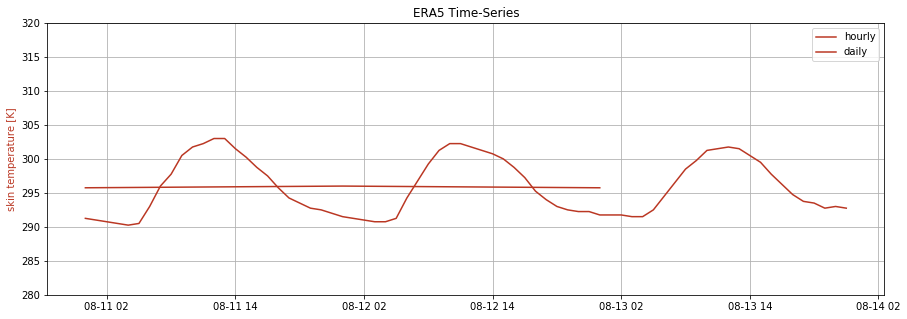

In [24]:
# Plot ERA5 skt and skt resampled variable(s) in same panel with two graphs
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(ts_era5_id2['2013-08-11': '2013-08-13']['skt'], color='#BA3723', label='hourly')
ax.plot(ts_resample_id2['2013-08-11': '2013-08-13']['skt'], color='#BA3723', label='daily')

ax.set_ylim(280, 320)
ax.set_title('ERA5 Time-Series')
ax.set_ylabel('skin temperature [K]', color='#BA3723')
ax.grid(b=True)

plt.legend()

filename = os.path.join(exercize_path_img, "ex3_ts_skt_cbeck_resampling.tiff")
fig.savefig(filename, dpi=120)

### Compute Soil Water Index (SWI) for ASCAT dataset

In [28]:
# Compute SWI for time-series 1
ts_sm = ts_resample_id1[['sm', 'sm_noise']]
# Get julian dates of time series 1
jd = ts_sm.index.to_julian_date().get_values()
# Calculate SWI T=1,5,10,50
ts_resample_id1['swi_t1'] = exp_filter(ts_sm['sm'].values, jd, ctime=1)
ts_resample_id1['swi_t5'] = exp_filter(ts_sm['sm'].values, jd, ctime=5)
ts_resample_id1['swi_t10'] = exp_filter(ts_sm['sm'].values, jd, ctime=10)
ts_resample_id1['swi_t50'] = exp_filter(ts_sm['sm'].values, jd, ctime=50)
# Print resampled time-series head
print(ts_resample_id1.head(n=3)); print(ts_resample_id1.tail(n=3)); 

               sm  sm_noise  snow_prob  frozen_prob     var40     var41  \
2007-04-27  0.300       7.0       33.0          0.0  0.657745  0.637360   
2007-04-30  0.250       7.0       33.0          0.0  0.578369  0.608368   
2007-05-01  0.355       7.0       11.0          0.0  0.594330  0.603119   

               var42     var43     skt        tp      index    swi_t1  \
2007-04-27  0.640564  0.662811  281.25  6.876051 2007-04-27  0.300000   
2007-04-30  0.629852  0.662323  281.25  1.168966 2007-04-30  0.252371   
2007-05-01  0.628265  0.662201  279.50  7.904351 2007-05-01  0.326408   

              swi_t5   swi_t10   swi_t50  
2007-04-27  0.300000  0.300000  0.300000  
2007-04-30  0.267717  0.271278  0.274250  
2007-05-01  0.306201  0.303789  0.302063  
                  sm  sm_noise  snow_prob  frozen_prob     var40     var41  \
2014-12-26  0.653333       6.0       22.0         21.0  0.687592  0.803162   
2014-12-27  0.600000       7.0       11.0         11.0  0.523560  0.791382   


In [29]:
# Compute SWI for time-series 2
ts_sm = ts_resample_id2[['sm', 'sm_noise']]
# Get julian dates of time series 2
jd = ts_sm.index.to_julian_date().get_values()
# Calculate SWI T=1,5,10,50
ts_resample_id2['swi_t1'] = exp_filter(ts_sm['sm'].values, jd, ctime=1)
ts_resample_id2['swi_t5'] = exp_filter(ts_sm['sm'].values, jd, ctime=5)
ts_resample_id2['swi_t10'] = exp_filter(ts_sm['sm'].values, jd, ctime=10)
ts_resample_id2['swi_t50'] = exp_filter(ts_sm['sm'].values, jd, ctime=50)

### Scaling of the two time-series using mean-std method

In [30]:
# Scale swi (swi_t5, var40)
ts_resample_id1['swi_t5_scaled'] = scaling_method_ms(ts_resample_id1['swi_t5'], ts_resample_id1['var40'])
# Print time-series head
print(ts_resample_id1.head(n=3)); print(ts_resample_id1.tail(n=3)); 

               sm  sm_noise  snow_prob  frozen_prob     var40     var41  \
2007-04-27  0.300       7.0       33.0          0.0  0.657745  0.637360   
2007-04-30  0.250       7.0       33.0          0.0  0.578369  0.608368   
2007-05-01  0.355       7.0       11.0          0.0  0.594330  0.603119   

               var42     var43     skt        tp      index    swi_t1  \
2007-04-27  0.640564  0.662811  281.25  6.876051 2007-04-27  0.300000   
2007-04-30  0.629852  0.662323  281.25  1.168966 2007-04-30  0.252371   
2007-05-01  0.628265  0.662201  279.50  7.904351 2007-05-01  0.326408   

              swi_t5   swi_t10   swi_t50  swi_t5_scaled  
2007-04-27  0.300000  0.300000  0.300000       0.711006  
2007-04-30  0.267717  0.271278  0.274250       0.680163  
2007-05-01  0.306201  0.303789  0.302063       0.716930  
                  sm  sm_noise  snow_prob  frozen_prob     var40     var41  \
2014-12-26  0.653333       6.0       22.0         21.0  0.687592  0.803162   
2014-12-27  0.6000

In [31]:
# Scale swi (swi_t5, var40)
ts_resample_id2['swi_t5_scaled'] = scaling_method_ms(ts_resample_id2['swi_t5'], ts_resample_id2['var40'])
# Print time-series head
print(ts_resample_id2.head(n=3)); print(ts_resample_id2.tail(n=3)); 

              sm  sm_noise  snow_prob  frozen_prob     var40     var41  \
2007-01-01  0.26       7.0      127.0          0.0  0.752747  0.758453   
2007-01-02  0.39       6.0      127.0          0.0  0.745575  0.755341   
2007-01-03  0.19       7.0      127.0          0.0  0.716217  0.750183   

               var42     var43     skt        tp      index    swi_t1  \
2007-01-01  0.752960  0.661316  280.25  0.014186 2007-01-01  0.260000   
2007-01-02  0.752655  0.661560  279.00  0.000000 2007-01-02  0.355038   
2007-01-03  0.751892  0.661713  277.75  0.000000 2007-01-03  0.245248   

              swi_t5   swi_t10   swi_t50  swi_t5_scaled  
2007-01-01  0.260000  0.260000  0.260000       0.541500  
2007-01-02  0.331478  0.328247  0.325650       0.622498  
2007-01-03  0.274638  0.277488  0.279526       0.558088  
                  sm  sm_noise  snow_prob  frozen_prob     var40     var41  \
2014-12-29  0.400000       7.0      127.0          0.0  0.693359  0.823639   
2014-12-30  0.080000  

### Plot time-series

#### 1. Plot ERA5 variables (tp: total precipitation, skt: skin temperature)

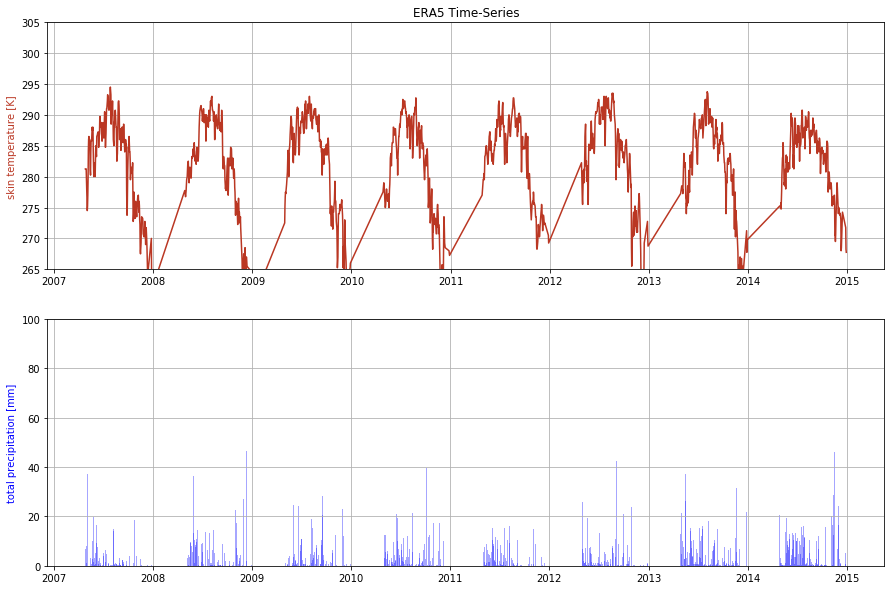

In [32]:
# Plot ERA5 skt and tp variable(s) in same panel with two graphs
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
axs[0].plot(ts_resample_id1['skt'], color='#BA3723')
axs[1].bar(ts_resample_id1['tp'].index, ts_resample_id1['tp'].values, color='#0000FF', alpha=0.35, width=2, align='edge')

axs[0].set_ylim(265, 305)
axs[0].set_title('ERA5 Time-Series')
axs[0].set_ylabel('skin temperature [K]', color='#BA3723')
axs[0].grid(b=True)

axs[1].set_ylim(0, 100)
axs[1].set_ylabel('total precipitation [mm]', color='#0000FF')
axs[1].grid(b=True) 

filename = os.path.join(exercize_path_img, "ex3_ts_skt_tp.tiff")
fig.savefig(filename, dpi=120)

#### 2. Plot ASCAT and ERA5 soil moisture variables (sm vs var40)

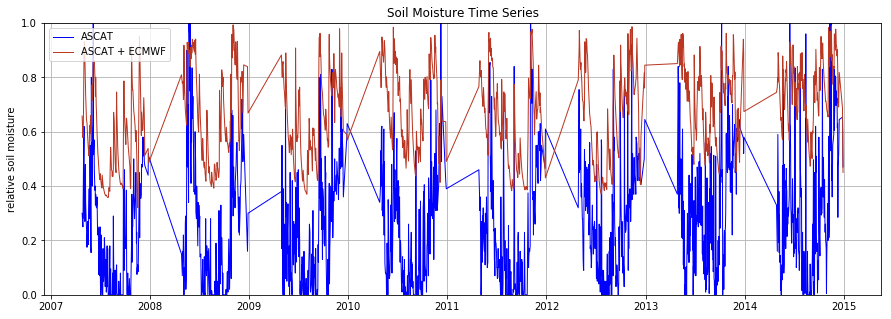

In [33]:
# Plot ASCAT and RZSM soil moisture variable(s)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(ts_resample_id1['sm'], lw=1, color='#0000FF', label='ASCAT')
ax.plot(ts_resample_id1['var40'], lw=1, color='#BA3723', label='ASCAT + ECMWF')

ax.set_ylim(0, 1)
ax.set_title('Soil Moisture Time Series')
ax.set_ylabel('relative soil moisture')
ax.grid(b=True)
plt.legend()

filename = os.path.join(exercize_path_img, "ex3_ts_sm_var40.tiff")
fig.savefig(filename, dpi=120)

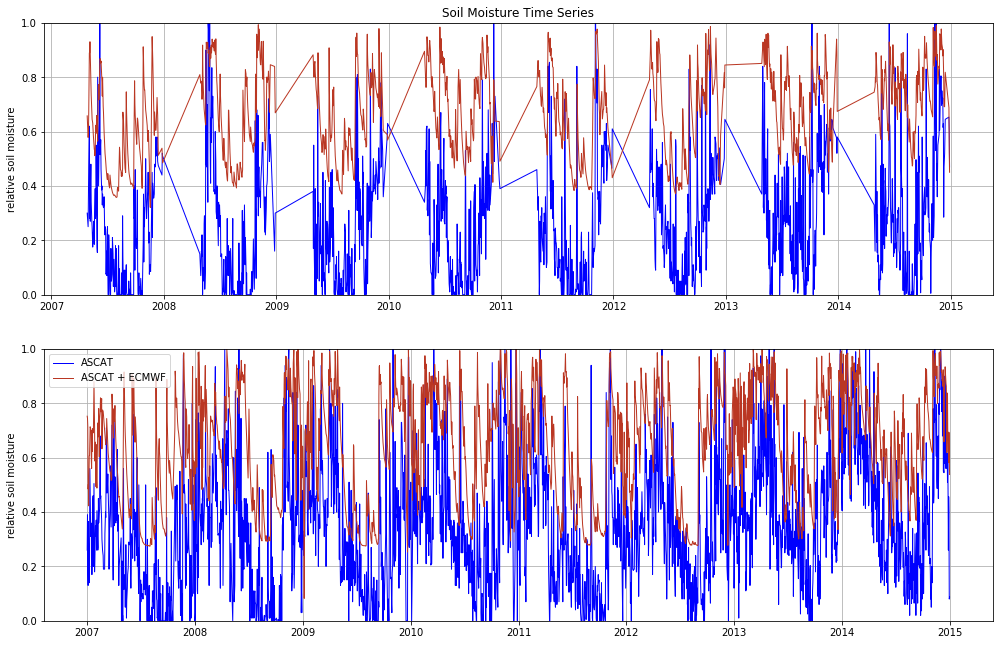

In [34]:
# Plot ASCAT and RZSM soil moisture variable(s) for two gpis
fig, axs = plt.subplots(2, 1, figsize=(17, 11))
axs[0].plot(ts_resample_id1['sm'], lw=1, color='#0000FF', label='ASCAT')
axs[0].plot(ts_resample_id1['var40'], lw=1, color='#BA3723', label='ASCAT + ECMWF')

axs[1].plot(ts_resample_id2['sm'], lw=1, color='#0000FF', label='ASCAT')
axs[1].plot(ts_resample_id2['var40'], lw=1, color='#BA3723', label='ASCAT + ECMWF')

axs[0].set_ylim(0, 1)
axs[0].set_title('Soil Moisture Time Series')
axs[0].set_ylabel('relative soil moisture')
axs[0].grid(b=True)
plt.legend()

axs[1].set_ylim(0, 1)
axs[1].set_ylabel('relative soil moisture')
axs[1].grid(b=True)
plt.legend()

filename = os.path.join(exercize_path_img, "ex3_ts_sm_var40_2gpis.tiff")
fig.savefig(filename, dpi=120)

### Subset (zoom) for ASCAT, ERA5 and RZSM time-series
* Select time window to plot datasets
* Modify time_start_period and time_end_period

In [35]:
# Extract ASCAT, ERA5 amd RZSM data by period
time_start_period = "2012-08-01"
time_end_period = "2012-10-31"
ts_resample_period_id1 = ts_resample_id1.loc[time_start_period:time_end_period]
ts_resample_period_id2 = ts_resample_id2.loc[time_start_period:time_end_period]
# Print resampled time-series period
print(ts_resample_period_id1.head(n=3)); print(ts_resample_period_id1.tail(n=3)); 

              sm  sm_noise  snow_prob  frozen_prob     var40     var41  \
2012-08-01  0.00       8.0        0.0          0.0  0.383240  0.394409   
2012-08-02  0.05       9.0        0.0          0.0  0.411926  0.393799   
2012-08-03  0.00       8.0        0.0          0.0  0.403107  0.392303   

               var42     var43     skt        tp      index    swi_t1  \
2012-08-01  0.500854  0.752502  291.00  2.271652 2012-08-01  0.006656   
2012-08-02  0.498413  0.751740  292.25  0.520647 2012-08-02  0.034057   
2012-08-03  0.494751  0.750854  292.75  0.020564 2012-08-03  0.012528   

              swi_t5   swi_t10   swi_t50  swi_t5_scaled  
2012-08-01  0.061336  0.100241  0.200921       0.482991  
2012-08-02  0.059196  0.095029  0.196870       0.480947  
2012-08-03  0.048104  0.085256  0.191624       0.470349  
              sm  sm_noise  snow_prob  frozen_prob     var40     var41  \
2012-10-29  0.25       7.0        0.0          0.0  0.735779  0.775757   
2012-10-30  0.17       8.0    

### Plot time-series

#### 1. Plot ASCAT and ERA5 soil moisture variables (sm vs var40)

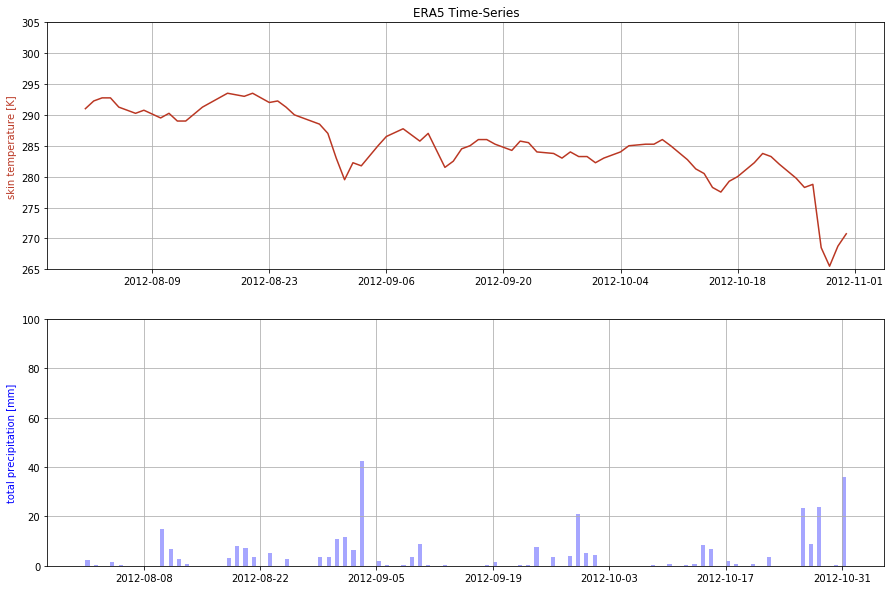

In [36]:
# Plot ERA5 skt and tp variable(s) in same panel with two graphs
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
axs[0].plot(ts_resample_period_id1['skt'], color='#BA3723')
axs[1].bar(ts_resample_period_id1['tp'].index, ts_resample_period_id1['tp'].values, color='#0000FF', alpha=0.35, width=0.5, align='edge')

axs[0].set_ylim(265, 305)
axs[0].set_title('ERA5 Time-Series')
axs[0].set_ylabel('skin temperature [K]', color='#BA3723')
axs[0].grid(b=True)

axs[1].set_ylim(0, 100)
axs[1].set_ylabel('total precipitation [mm]', color='#0000FF')
axs[1].grid(b=True) 

filename = os.path.join(exercize_path_img, "ex3_ts_skt_tp_period.tiff")
fig.savefig(filename, dpi=120)

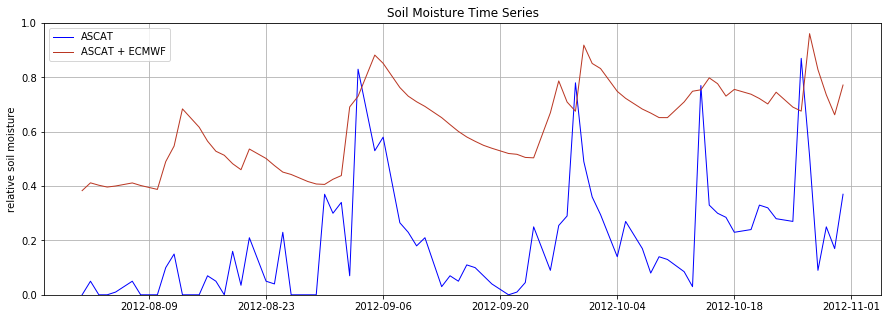

In [37]:
# Plot ASCAT and RZSM soil moisture variable(s)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(ts_resample_period_id1['sm'], lw=1, color='#0000FF', label='ASCAT')
ax.plot(ts_resample_period_id1['var40'], lw=1, color='#BA3723', label='ASCAT + ECMWF')

ax.set_ylim(0, 1)
ax.set_title('Soil Moisture Time Series')
ax.set_ylabel('relative soil moisture')
ax.grid(b=True)
plt.legend()

filename = os.path.join(exercize_path_img, "ex3_ts_sm_var40_period.tiff")
fig.savefig(filename, dpi=120)

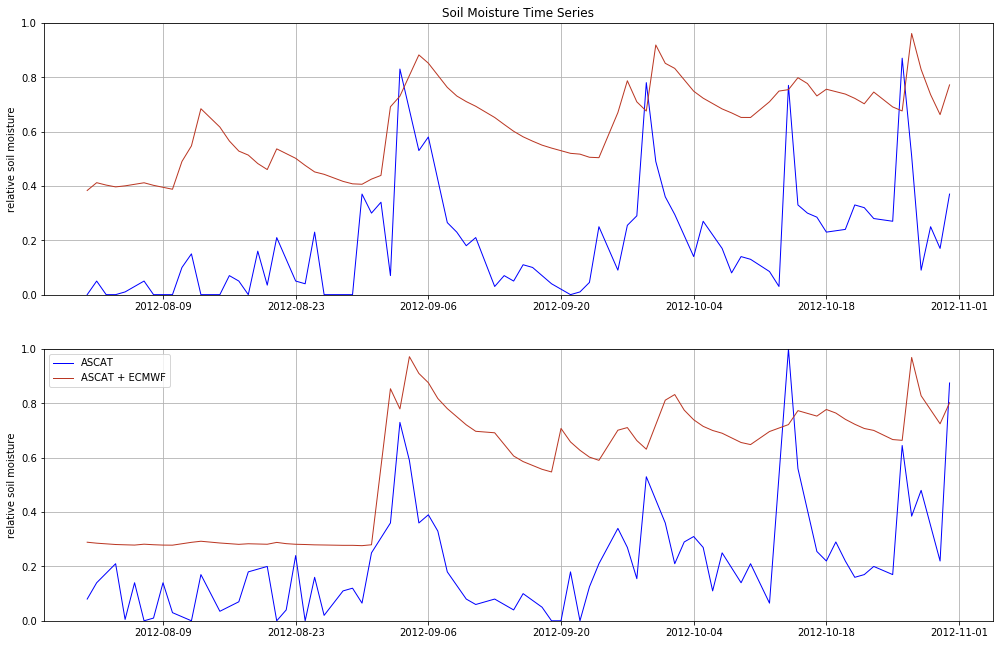

In [38]:
# Plot ASCAT and RZSM soil moisture variable(s) for two gpis
fig, axs = plt.subplots(2, 1, figsize=(17, 11))
axs[0].plot(ts_resample_period_id1['sm'], lw=1, color='#0000FF', label='ASCAT')
axs[0].plot(ts_resample_period_id1['var40'], lw=1, color='#BA3723', label='ASCAT + ECMWF')

axs[1].plot(ts_resample_period_id2['sm'], lw=1, color='#0000FF', label='ASCAT')
axs[1].plot(ts_resample_period_id2['var40'], lw=1, color='#BA3723', label='ASCAT + ECMWF')

axs[0].set_ylim(0, 1)
axs[0].set_title('Soil Moisture Time Series')
axs[0].set_ylabel('relative soil moisture')
axs[0].grid(b=True)
plt.legend()

axs[1].set_ylim(0, 1)
axs[1].set_ylabel('relative soil moisture')
axs[1].grid(b=True)
plt.legend()

filename = os.path.join(exercize_path_img, "ex3_ts_sm_var40_period_2gpis.tiff")
fig.savefig(filename, dpi=120)

#### 2. Plot ASCAT ssm and soil water index at different T

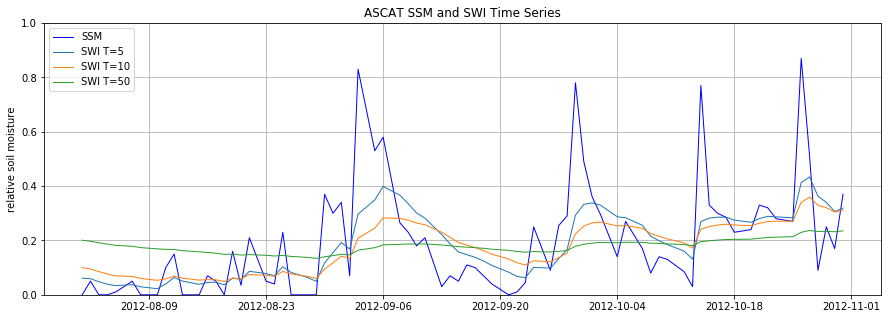

In [39]:
# Plot ASCAT SSM, SWI-T5, SWI-T10, SWI-T50 variable(s)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(ts_resample_period_id1['sm'], lw=1, color='#0000FF', label='SSM')
ax.plot(ts_resample_period_id1['swi_t5'], lw=1, label='SWI T=5')
ax.plot(ts_resample_period_id1['swi_t10'], lw=1, label='SWI T=10')
ax.plot(ts_resample_period_id1['swi_t50'], lw=1, label='SWI T=50')

ax.set_ylim(0, 1)
ax.set_title('ASCAT SSM and SWI Time Series')
ax.set_ylabel('relative soil moisture')
ax.grid(b=True)
plt.legend()

filename = os.path.join(exercize_path_img, "ex3_ts_sm_swit5-10-50_period.tiff")
fig.savefig(filename, dpi=120)

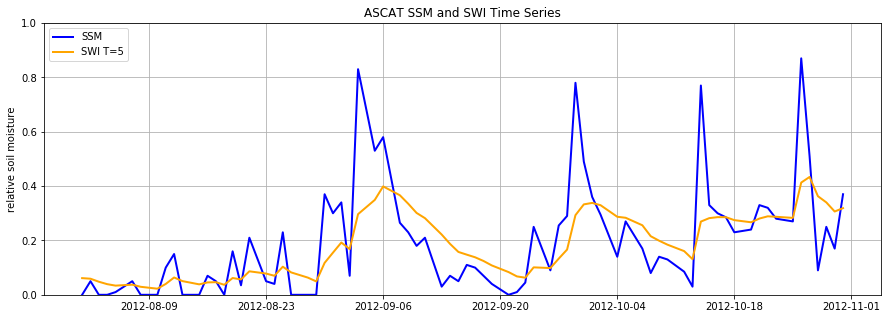

In [40]:
# Plot ASCAT SSM, SWI-T5, SWI-T10, SWI-T50 variable(s)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(ts_resample_period_id1['sm'], lw=2, color='#0000FF', label='SSM')
ax.plot(ts_resample_period_id1['swi_t5'], lw=2, label='SWI T=5', color='#FFA500')

ax.set_ylim(0, 1)
ax.set_title('ASCAT SSM and SWI Time Series')
ax.set_ylabel('relative soil moisture')
ax.grid(b=True)
plt.legend()

filename = os.path.join(exercize_path_img, "ex3_ts_sm_swit5_period.tiff")
fig.savefig(filename, dpi=120)

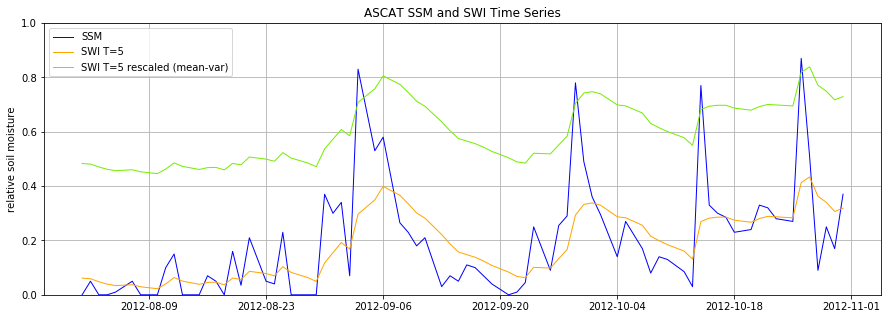

In [41]:
# Plot ASCAT SSM, SWI-T5, SWI-T10, SWI-T50 variable(s)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(ts_resample_period_id1['sm'], lw=1, color='#0000FF', label='SSM')
ax.plot(ts_resample_period_id1['swi_t5'], lw=1, label='SWI T=5', color='#FFA500')
ax.plot(ts_resample_period_id1['swi_t5_scaled'], lw=1, color='#76EE00', label='SWI T=5 rescaled (mean-var)')

ax.set_ylim(0, 1)
ax.set_title('ASCAT SSM and SWI Time Series')
ax.set_ylabel('relative soil moisture')
ax.grid(b=True)
plt.legend()

filename = os.path.join(exercize_path_img, "ex3_ts_sm_swit5_swit5scale_period.tiff")
fig.savefig(filename, dpi=120)

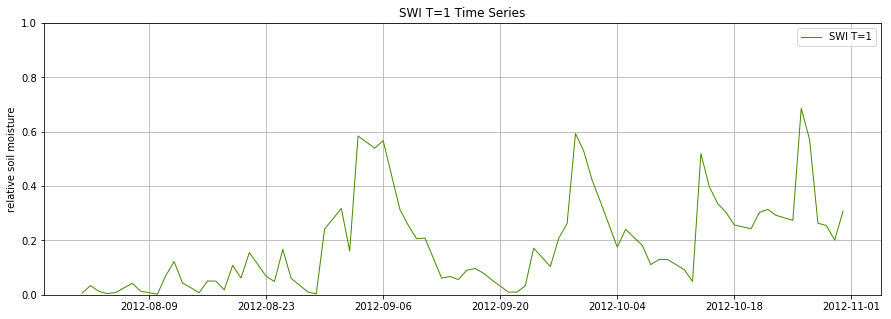

In [42]:
# Plot ASCAT SWI T=1 timeseries
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
axs.plot(ts_resample_period_id1['swi_t1'], lw=1, color='#458B00', label='SWI T=1')

axs.set_ylim(0, 1)
axs.set_title('SWI T=1 Time Series')
axs.set_ylabel('relative soil moisture')
axs.grid(b=True)

plt.legend()

filename = os.path.join(exercize_path_img, "ex3_ts_sm_swit1_period.tiff")
fig.savefig(filename, dpi=120)

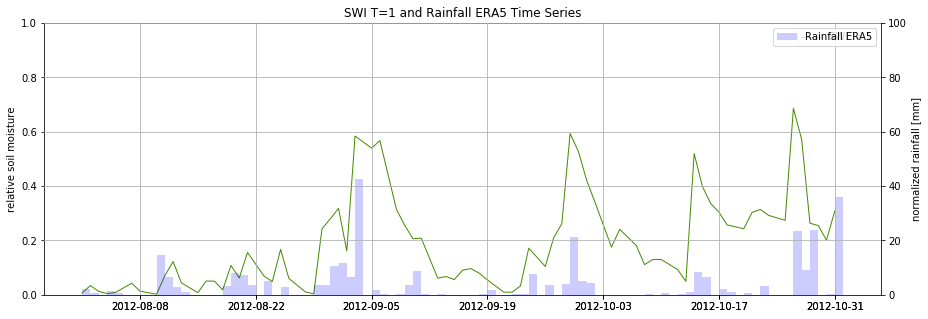

In [43]:
# Plot ASCAT SWI T=1 and ERA5 Rainfall timeseries
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(111)
ax1.plot(ts_resample_period_id1['swi_t1'], lw=1, color='#458B00', label = 'SWI T=1')
ax1.set_ylim(0, 1)
ax1.legend()

plt.title('SWI T=1 and Rainfall ERA5 Time Series')
plt.ylabel("relative soil moisture")

ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.bar(ts_resample_period_id1['tp'].index, ts_resample_period_id1['tp'].values, 
              label = 'Rainfall ERA5', color='#0000FF', alpha=0.2, width=1, align='edge')
ax2.set_ylim(0, 100)
ax2.legend()

plt.ylabel("normalized rainfall [mm]")

plt.grid()

filename = os.path.join(exercize_path_img, "ex3_ts_sm_swit1_tp_period.tiff")
fig.savefig(filename, dpi=120)

#### Prepare a presentation containing:
* Visualization and comparison of soil moisture time series at one point
* Visualization and comparison of time series at two points in the study area
* Analysis of the periods (in time) to be masked out due to frozen conditions (if any), suspicious and missing data
* Application of the Soil Water Index to ASCAT soil moisture products for different T-values
* Application of rescaling techniques to make soil moisture time series in the same range of values
* Comparison of precipitation and soil moisture time series
##### the results will be shared during the WG presentation on Friday